('...evaluating matrix...', (9, 9), (9, 9), (9, 9))
(0,0)
('numerical integration of', sin(pi*x)**2*sin(pi*y)**2)
('numerical integration of', x*y*(1 - x)*(1 - y)*exp(-x - y)*sin(pi*x)*sin(pi*y))
(1,1)
('numerical integration of', sin(2*pi*x)**2*sin(pi*y)**2)
('numerical integration of', x*y*(1 - x)*(1 - y)*exp(-x - y)*sin(2*pi*x)*sin(pi*y))
(2,2)
('numerical integration of', sin(3*pi*x)**2*sin(pi*y)**2)
('numerical integration of', x*y*(1 - x)*(1 - y)*exp(-x - y)*sin(3*pi*x)*sin(pi*y))
(3,3)
('numerical integration of', sin(pi*x)**2*sin(2*pi*y)**2)
('numerical integration of', x*y*(1 - x)*(1 - y)*exp(-x - y)*sin(pi*x)*sin(2*pi*y))
(4,4)
('numerical integration of', sin(2*pi*x)**2*sin(2*pi*y)**2)
('numerical integration of', x*y*(1 - x)*(1 - y)*exp(-x - y)*sin(2*pi*x)*sin(2*pi*y))
(5,5)
('numerical integration of', sin(3*pi*x)**2*sin(2*pi*y)**2)
('numerical integration of', x*y*(1 - x)*(1 - y)*exp(-x - y)*sin(3*pi*x)*sin(2*pi*y))
(6,6)
('numerical integration of', sin(pi*x)**2*sin(3*pi

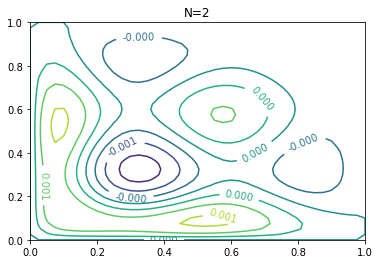

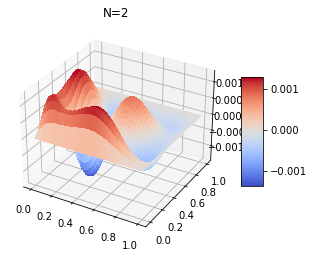

[0.0253389800529911, 0.00473082561373854, 0.00144216451645746, 0.00473082561373854, 0.000883252243807765, 0.000269254280141257, 0.00144216451645746, 0.000269254280141257, 8.20805923592598e-5]


In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.pardir, 'src'))
import sympy as sym
import mpmath

def least_squares_orth(f, psi, Omega, symbolic=True,
                       print_latex=False):
    """
    Given a function f(x,y) on a rectangular domain
    Omega=[[xmin,xmax],[ymin,ymax]],
    return the best approximation to f(x,y) in the space V
    spanned by the functions in the list psi.
    This function assumes that psi are orthogonal on Omega.
    """
    # Modification of least_squares function: drop the j loop,
    # set j=i, compute c on the fly in the i loop.

    N = len(psi) - 1
    # Note that A, b, c becmes (N+1)x(N+1), use 1st column
    A = sym.zeros(N+1)
    b = sym.zeros(N+1)
    c = sym.zeros(N+1)
    x, y = sym.symbols('x y')
    print(('...evaluating matrix...', A.shape, b.shape, c.shape))
    for i in range(N+1):
        j = i
        print(('(%d,%d)' % (i, j)))

        integrand = psi[i]*psi[j]
        if symbolic:
            I = sym.integrate(integrand,
                             (x, Omega[0][0], Omega[0][1]),
                             (y, Omega[1][0], Omega[1][1]))
        if not symbolic or isinstance(I, sym.Integral):
            # Could not integrate symbolically, use numerical int.
            print(('numerical integration of', integrand))
            integrand = sym.lambdify([x,y], integrand, 'mpmath')
            I = mpmath.quad(integrand,
                            [Omega[0][0], Omega[0][1]],
                            [Omega[1][0], Omega[1][1]])
        A[i,0] = I

        integrand = psi[i]*f
        if symbolic:
            I = sym.integrate(integrand,
                             (x, Omega[0][0], Omega[0][1]),
                             (y, Omega[1][0], Omega[1][1]))
        if not symbolic or isinstance(I, sym.Integral):
            # Could not integrate symbolically, use numerical int.
            print(('numerical integration of', integrand))
            integrand = sym.lambdify([x,y], integrand, 'mpmath')
            I = mpmath.quad(integrand,
                            [Omega[0][0], Omega[0][1]],
                            [Omega[1][0], Omega[1][1]])
        b[i,0] = I
        c[i,0] = b[i,0]/A[i,0]
    print()
    print(('A:\n', A, '\nb:\n', b))
    c = [c[i,0] for i in range(c.shape[0])]  # make list
    print(('coeff:', c))

    # c is a sympy Matrix object, numbers are in c[i,0]
    u = sum(c[i]*psi[i] for i in range(len(psi)))
    print(('approximation:', u))
    print(('f:', sym.expand(f)))
    if print_latex:
        print((sym.latex(A, mode='plain')))
        print((sym.latex(b, mode='plain')))
        print((sym.latex(c, mode='plain')))
    return u, c

def sine_basis(Nx, Ny):
    """
    Compute basis sin((p+1)*pi*x)*sin((q+1)*pi*y),
    p=0,...,Nx, q=0,...,Ny.
    """
    x, y = sym.symbols('x y')
    psi = []
    for q in range(0, Ny+1):
        for p in range(0, Nx+1):
            r = sym.sin((p+1)*sym.pi*x)*sym.sin((q+1)*sym.pi*y)
            psi.append(r)
    return psi

def test_least_squares_orth():
    # Use sine functions
    x, y = sym.symbols('x y')
    N = 2  # (N+1)**2 = 9 basis functions
    psi = sine_basis(N, N)
    f_coeff = [0]*len(psi)
    f_coeff[3] = 2
    f_coeff[4] = 3
    f = sum(f_coeff[i]*psi[i] for i in range(len(psi)))
    # Check that u exactly reproduces f
    u, c = least_squares_orth(f, psi, Omega=[[0,1], [0,1]],
                              symbolic=False)
    import numpy as np
    diff = np.abs(np.array(c) - np.array(f_coeff)).max()
    print(('diff:', diff))
    tol = 1E-15
    assert diff < tol

def demo(N):
    """
    Find the approximation of f by the least squares method.
    The basis is sin((p+1)*pi*x)sin((q+1)*pi*y) where
    0<p<=N, p<q<=N.
    """
    x, y = sym.symbols('x y')
    f = x*(1-x)*y*(1-y)*sym.exp(-x-y)

    psi = sine_basis(N, N)

    Omega = [[0,1], [0,1]]
    u, c  = least_squares_orth(f, psi, Omega, symbolic=False)
    from approx2D import comparison_plot
    comparison_plot(f, u, Omega, title='N=%d' % N)
    print(c)

if __name__=='__main__':
    #test_least_squares_orth()
    demo(N=2)
